## This code takes the .npz file from TweetyBERT, as well as the surgery date from the bird's creation_data .json file, then color-codes data from pre versus post treatment (e.g. surgery, DOI injection).

### Load the .npz file and the .json file, extract the animal_id, treatment_date, and treatmetn_type (to be used in the graph titles later)

In [146]:
import re
import numpy as np
import json

# Paths to the .npz and .json files
path_to_npz_file_from_TweetyBERT = '/Volumes/Rose-SSD/NPZs_from_TweetyBERT/USA5336.npz'
path_to_json_file_with_dates = '/Volumes/Rose-SSD/NPZs_from_TweetyBERT/USA5336_creation_data.json'

# Use a regular expression to find the pattern 'USA' followed by 4 digits for the animal ID
match = re.search(r"(USA\d{4})", path_to_json_file_with_dates)
if match:
    animal_id = match.group(1)
    print(f"Animal ID: {animal_id}")
else:
    print("Animal ID not found in the file path.")

# Load the JSON file and extract the treatment date
with open(path_to_json_file_with_dates, 'r') as file:
    json_data = json.load(file)

# Extract and print the treatment date
treatment_date = json_data.get("treatment_date", "Treatment date not found")
treatment_type = json_data.get("treatment_type", "Treatment type not found")
print(f"Treatment Date: {treatment_date}")
print(f"Treatment Type: {treatment_type}")

print(path_to_json_file_with_dates)


Animal ID: USA5336
Treatment Date: 2024-01-23
Treatment Type: Bilateral Area X lesion
/Volumes/Rose-SSD/NPZs_from_TweetyBERT/USA5336_creation_data.json


## Adjust the dictionary to include the date of the recording.

In [147]:
import numpy as np
import json

# # Paths to the files
# path_to_npz_file_from_TweetyBERT = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508.npz'
# path_to_json_file_with_dates = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508_creation_data.json'

# Load the .npz file
data = np.load(path_to_npz_file_from_TweetyBERT, allow_pickle=True)

# Extract the dictionary
file_map_dictionary = data['file_map'].item()

# Load the creation_data.json
with open(path_to_json_file_with_dates, 'r') as json_file:
    creation_data = json.load(json_file)

# Extract the year from 'treatment_date'
treatment_date = creation_data.get('treatment_date')
if treatment_date is None:
    raise ValueError("Treatment date not found in creation_data.")

# Parse the year from the 'treatment_date'
year = treatment_date.split('-')[0]

# Iterate over each key in the file_map_dictionary
for key in file_map_dictionary.keys():
    # Get the filename tuple
    filename_tuple = file_map_dictionary[key]
    
    # Extract the filename string
    sample_file_name = filename_tuple[0]
    
    # Split the string by underscores
    parts = sample_file_name.split('_')
    
    # Extract date and time components
    try:
        month = parts[2]  # '10' - October
        day = parts[3]    # '8'
        hour = parts[4]   # '12'
        minute = parts[5] # '33'
    except IndexError:
        print(f"Error: Filename parts do not have enough components for key {key}. Skipping.")
        continue  # Skip to the next key
    
    # Ensure all components are two digits
    month = month.zfill(2)
    day = day.zfill(2)
    hour = hour.zfill(2)
    minute = minute.zfill(2)
    
    # Validate numeric ranges
    try:
        hour_int = int(hour)
        minute_int = int(minute)
        if not (0 <= hour_int < 24):
            print(f"Invalid hour value: {hour_int} for key {key}. Skipping.")
            continue  # Skip to the next key
        if not (0 <= minute_int < 60):
            print(f"Invalid minute value: {minute_int} for key {key}. Skipping.")
            continue  # Skip to the next key
    except ValueError:
        print(f"Invalid numeric value in date components for key {key}. Skipping.")
        continue  # Skip to the next key
    
    # Create datetime string
    datetime_str = f"{year}-{month}-{day}T{hour}:{minute}"
    
    # Convert to NumPy datetime64
    datetime_np = np.datetime64(datetime_str)
    
    # Update the tuple to include datetime_np
    new_tuple = filename_tuple + (datetime_np,)
    
    # Update the dictionary
    file_map_dictionary[key] = new_tuple

# Now, file_map_dictionary has updated tuples with datetime included

# Optional: To verify the updates, you can print the updated file_map_dictionary
for key, value in file_map_dictionary.items():
    print(f"Key: {key}, Value: {value}")

# Corrected variable name
print(file_map_dictionary)

Key: 0, Value: ('USA5336_45305.33360696_1_14_9_16_0_segment_0.npz', numpy.datetime64('2024-01-14T09:16'))
Key: 1, Value: ('USA5336_45326.30499426_2_4_8_28_19_segment_0.npz', numpy.datetime64('2024-02-04T08:28'))
Key: 2, Value: ('USA5336_45220.23951738_10_21_6_39_11_segment_1.npz', numpy.datetime64('2024-10-21T06:39'))
Key: 3, Value: ('USA5336_45216.39778365_10_17_11_2_58_segment_0.npz', numpy.datetime64('2024-10-17T11:02'))
Key: 4, Value: ('USA5336_45220.59240426_10_21_16_27_20_segment_1.npz', numpy.datetime64('2024-10-21T16:27'))
Key: 5, Value: ('USA5336_45230.47700487_10_31_13_15_0_segment_0.npz', numpy.datetime64('2024-10-31T13:15'))
Key: 6, Value: ('USA5336_45230.43654957_10_31_12_7_34_segment_2.npz', numpy.datetime64('2024-10-31T12:07'))
Key: 7, Value: ('USA5336_45216.30037928_10_17_8_20_37_segment_0.npz', numpy.datetime64('2024-10-17T08:20'))
Key: 8, Value: ('USA5336_45221.30952749_10_22_8_35_52_segment_0.npz', numpy.datetime64('2024-10-22T08:35'))
Key: 9, Value: ('USA5336_45236.

### Now, make an organized table that contains the date of the recording, and the point in UMAP space. This will require iterating through each coordinate, finding the corresonding file_index, then using that to get the file name and date from the updated file_map_dictionary.

In [148]:
import numpy as np
import datetime

# Let's start out by doing this all for the first data point.
sample_index = 0
UMAP_space_coordinate = data['embedding_outputs'][sample_index]
print(f"UMAP Space Coordinate: {UMAP_space_coordinate}")

# Find the corresponding file_index value
sample_file_index = data['file_indices'][sample_index]
print(f"Sample File Index: {sample_file_index}")

# Use that as the key to find the filename and date
corresponding_file_map_dictionary_entry = file_map_dictionary[sample_file_index]
print(f"Corresponding File Map Entry: {corresponding_file_map_dictionary_entry}")

# Extract the numpy.datetime64 object
corresponding_date_time = corresponding_file_map_dictionary_entry[1]
print(f"Corresponding Date Time: {corresponding_date_time}")

# Convert numpy.datetime64 to datetime.datetime
datetime_obj = corresponding_date_time.astype('datetime64[s]').astype(datetime.datetime)

# Extract the date
corresponding_date = datetime_obj.date()
print(f"Corresponding Date: {corresponding_date}")


UMAP Space Coordinate: [6.807149 9.290283]
Sample File Index: 0
Corresponding File Map Entry: ('USA5336_45305.33360696_1_14_9_16_0_segment_0.npz', numpy.datetime64('2024-01-14T09:16'))
Corresponding Date Time: 2024-01-14T09:16
Corresponding Date: 2024-01-14


In [149]:
import numpy as np
import pandas as pd

# Assuming 'data' and 'file_map_dictionary' are already loaded as per your previous code.

# Convert file_map_dictionary to a DataFrame
file_map_df = pd.DataFrame.from_dict(file_map_dictionary, orient='index')

# Reset the index to ensure it aligns with sample_file_indices
file_map_df.reset_index(inplace=True)
file_map_df.rename(columns={'index': 'file_index'}, inplace=True)

# Extract the necessary columns
# Assuming the datetime is in the second position (column 1)
file_map_df = file_map_df[[0, 1]]
file_map_df.columns = ['Filename', 'DateTime']

# Extract the sample file indices as a numpy array
sample_file_indices = data['file_indices']

# Create a DataFrame for the sample file indices
sample_df = pd.DataFrame({'file_index': sample_file_indices})

# Merge the sample_df with file_map_df on 'file_index' to get the DateTime
merged_df = sample_df.merge(file_map_df, left_on='file_index', right_index=True, how='left')

# Extract the dates (convert numpy.datetime64 to date)
merged_df['Date'] = merged_df['DateTime'].values.astype('datetime64[D]')

# Assign the UMAP coordinates directly
merged_df['Coordinate'] = list(data['embedding_outputs'])

# Select only the necessary columns
final_df = merged_df[['Date', 'Coordinate']]

# Reset index if needed
final_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(final_df.head(10))


        Date              Coordinate
0 2024-01-14    [6.807149, 9.290283]
1 2024-01-14   [6.8039308, 9.282812]
2 2024-01-14    [6.803301, 9.294714]
3 2024-01-14    [6.789764, 9.288287]
4 2024-01-14   [6.8108153, 9.293208]
5 2024-01-14      [5.26247, 2.31943]
6 2024-01-14    [5.2758307, 2.34571]
7 2024-01-14   [5.276258, 2.3294196]
8 2024-01-14     [5.24627, 2.326985]
9 2024-01-14  [5.2371716, 2.3384867]


## Now, plot the data:

In [150]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Assuming 'final_df' is your DataFrame with 'Date' and 'Coordinate' columns

# # Convert the 'Coordinate' column into separate 'X' and 'Y' columns
# coordinates = pd.DataFrame(final_df['Coordinate'].tolist(), columns=['X', 'Y'])
# final_df = final_df.join(coordinates)

# # Create a scatter plot
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=final_df, x='X', y='Y', hue='Date', palette='viridis', s=50)

# # Customize the plot
# plt.title('Scatter Plot of Coordinates')
# plt.xlabel('UMAP Coordinate X')
# plt.ylabel('UMAP Coordinate Y')
# plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

# # Show the plot
# plt.show()


In [151]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches

# # Assuming 'final_df' is your DataFrame with 'Date' and 'Coordinate' columns

# # Ensure the 'Date' column is in datetime format
# final_df['Date'] = pd.to_datetime(final_df['Date'])

# # Convert the 'Coordinate' column into separate 'X' and 'Y' columns
# coordinates = pd.DataFrame(final_df['Coordinate'].tolist(), columns=['X', 'Y'])

# # Overwrite existing 'X' and 'Y' columns in 'final_df'
# final_df[['X', 'Y']] = coordinates

# # Define the cutoff date
# cutoff_date = pd.to_datetime('2024-10-21')

# # Assign colors based on the date
# final_df['Color'] = final_df['Date'].apply(lambda x: 'blue' if x < cutoff_date else 'red')

# # Create the scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(final_df['X'], final_df['Y'], c=final_df['Color'])

# # Customize the plot
# plt.title('')
# plt.xlabel('UMAP Dimension 1', fontsize = 24)
# plt.ylabel('UMAP Dimension 2', fontsize = 24)
# plt.tight_layout()

# # Create custom legend
# blue_patch = mpatches.Patch(color='blue', label='Before Treatment')
# red_patch = mpatches.Patch(color='red', label='On or After 2024-10-21')
# plt.legend(handles=[blue_patch, red_patch], loc='upper right')

# # Show the plot
# plt.show()


In [152]:
# import re
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# import json

# # Paths to the .npz and .json files
# path_to_npz_file_from_TweetyBERT = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508.npz'
# path_to_json_file_with_dates = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508_creation_data.json'

# # Use a regular expression to find the pattern 'USA' followed by 4 digits for the animal ID
# match = re.search(r"(USA\d{4})", path_to_npz_file_from_TweetyBERT)
# if match:
#     animal_id = match.group(1)
#     print(f"Animal ID: {animal_id}")
# else:
#     print("Animal ID not found in the file path.")

# # Load the JSON file and extract the treatment date and type
# with open(path_to_json_file_with_dates, 'r') as file:
#     json_data = json.load(file)

# treatment_date_str = json_data.get("treatment_date", "Treatment date not found")
# treatment_type = json_data.get("treatment_type", "Treatment type not found")
# print(f"Treatment Date: {treatment_date_str}")
# print(f"Treatment Type: {treatment_type}")

# # Convert treatment_date_str to datetime
# treatment_date = pd.to_datetime(treatment_date_str)

# # Assuming 'final_df' is your DataFrame with 'Date' and 'Coordinate' columns
# # Ensure 'final_df' is already defined from previous steps

# # Ensure the 'Date' column is in datetime format
# final_df['Date'] = pd.to_datetime(final_df['Date'])

# # Convert the 'Coordinate' column into separate 'X' and 'Y' columns
# # Overwrite existing 'X' and 'Y' columns if they exist
# coordinates = pd.DataFrame(final_df['Coordinate'].tolist(), columns=['X', 'Y'])
# final_df[['X', 'Y']] = coordinates

# # Define the cutoff date using treatment_date
# cutoff_date = treatment_date

# # Assign colors based on the date relative to the treatment date
# final_df['Color'] = final_df['Date'].apply(lambda x: 'blue' if x < cutoff_date else 'red')

# # Create the scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(final_df['X'], final_df['Y'], c=final_df['Color'])

# # Customize the plot
# title_text = f"{animal_id} - {treatment_type} on {treatment_date_str}"
# plt.title(title_text)
# plt.xlabel('UMAP Coordinate X')
# plt.ylabel('UMAP Coordinate Y')
# plt.tight_layout()

# # Create custom legend entries
# blue_patch = mpatches.Patch(color='blue', label=f'Before {treatment_type}')
# red_patch = mpatches.Patch(color='red', label=f'On or After {treatment_type}')
# plt.legend(handles=[blue_patch, red_patch], loc='upper right')

# # Show the plot
# plt.show()


In [153]:
# import re
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# import json

# # Paths to the .npz and .json files
# path_to_npz_file_from_TweetyBERT = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508.npz'
# path_to_json_file_with_dates = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508_creation_data.json'

# # Use a regular expression to find the pattern 'USA' followed by 4 digits for the animal ID
# match = re.search(r"(USA\d{4})", path_to_npz_file_from_TweetyBERT)
# if match:
#     animal_id = match.group(1)
#     print(f"Animal ID: {animal_id}")
# else:
#     print("Animal ID not found in the file path.")

# # Load the JSON file and extract the treatment date and type
# with open(path_to_json_file_with_dates, 'r') as file:
#     json_data = json.load(file)

# treatment_date_str = json_data.get("treatment_date", "Treatment date not found")
# treatment_type = json_data.get("treatment_type", "Treatment type not found")
# print(f"Treatment Date: {treatment_date_str}")
# print(f"Treatment Type: {treatment_type}")

# # Convert treatment_date_str to datetime
# treatment_date = pd.to_datetime(treatment_date_str)

# # Assuming 'final_df' is your DataFrame with 'Date' and 'Coordinate' columns
# # Ensure 'final_df' is already defined from previous steps

# # Ensure the 'Date' column is in datetime format
# final_df['Date'] = pd.to_datetime(final_df['Date'])

# # Convert the 'Coordinate' column into separate 'X' and 'Y' columns
# # Overwrite existing 'X' and 'Y' columns if they exist
# coordinates = pd.DataFrame(final_df['Coordinate'].tolist(), columns=['X', 'Y'])
# final_df[['X', 'Y']] = coordinates

# # Define the cutoff date using treatment_date
# cutoff_date = treatment_date

# # Assign colors based on the date relative to the treatment date
# final_df['Color'] = final_df['Date'].apply(lambda x: 'blue' if x < cutoff_date else 'red')

# # Create the scatter plot with increased transparency
# plt.figure(figsize=(10, 6))
# plt.scatter(final_df['X'], final_df['Y'], c=final_df['Color'], alpha=0.3)

# # Customize the plot
# title_text = f"{animal_id} - {treatment_type} on {treatment_date_str}"
# plt.title(title_text)
# plt.xlabel('UMAP Coordinate X')
# plt.ylabel('UMAP Coordinate Y')
# plt.tight_layout()

# # Create custom legend entries
# blue_patch = mpatches.Patch(color='blue', label=f'Before {treatment_type}')
# red_patch = mpatches.Patch(color='red', label=f'On or After {treatment_type}')
# plt.legend(handles=[blue_patch, red_patch], loc='upper right')

# # Show the plot
# plt.show()


Animal ID: USA5336
Treatment Date: 2024-01-23
Treatment Type: Bilateral Area X lesion


/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_36653/4141371650.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Date'] = pd.to_datetime(final_df['Date'])
/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_36653/4141371650.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[['X', 'Y']] = coordinates
/var/folders/f4/1h7zvz4d1fxc5m8g17h70mfm0000gn/T/ipykernel_36653/4141371650.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

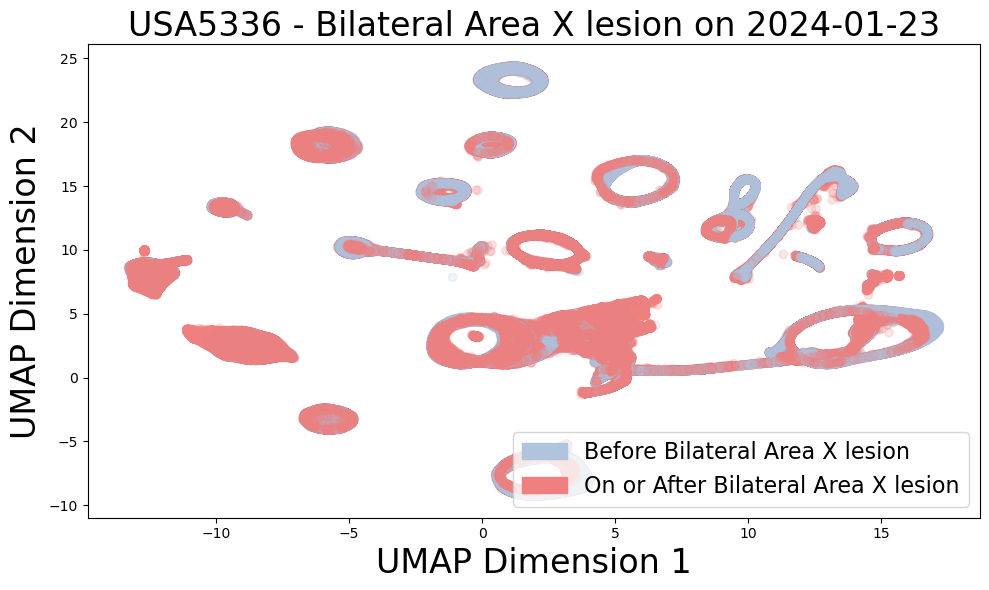

In [154]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json

# Paths to the .npz and .json files
# path_to_npz_file_from_TweetyBERT = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508.npz'
# path_to_json_file_with_dates = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508_creation_data.json'

# Use a regular expression to find the pattern 'USA' followed by 4 digits for the animal ID
match = re.search(r"(USA\d{4})", path_to_npz_file_from_TweetyBERT)
if match:
    animal_id = match.group(1)
    print(f"Animal ID: {animal_id}")
else:
    print("Animal ID not found in the file path.")

# Load the JSON file and extract the treatment date and type
with open(path_to_json_file_with_dates, 'r') as file:
    json_data = json.load(file)

treatment_date_str = json_data.get("treatment_date", "Treatment date not found")
treatment_type = json_data.get("treatment_type", "Treatment type not found")
print(f"Treatment Date: {treatment_date_str}")
print(f"Treatment Type: {treatment_type}")

# Convert treatment_date_str to datetime
treatment_date = pd.to_datetime(treatment_date_str)

# Assuming 'final_df' is your DataFrame with 'Date' and 'Coordinate' columns
# Ensure 'final_df' is already defined from previous steps

# Ensure the 'Date' column is in datetime format
final_df['Date'] = pd.to_datetime(final_df['Date'])

# Convert the 'Coordinate' column into separate 'X' and 'Y' columns
# Overwrite existing 'X' and 'Y' columns if they exist
coordinates = pd.DataFrame(final_df['Coordinate'].tolist(), columns=['X', 'Y'])
final_df[['X', 'Y']] = coordinates

# Define the cutoff date using treatment_date
cutoff_date = treatment_date

# Assign muted colors based on the date relative to the treatment date
# Use lighter shades of blue and red
final_df['Color'] = final_df['Date'].apply(lambda x: 'lightsteelblue' if x < cutoff_date else 'lightcoral')

# Create the scatter plot with increased transparency
plt.figure(figsize=(10, 6))
plt.scatter(final_df['X'], final_df['Y'], c=final_df['Color'], alpha=0.2)

# Customize the plot
title_text = f"{animal_id} - {treatment_type} on {treatment_date_str}"
plt.title(title_text, fontsize = 24)
plt.xlabel('UMAP Dimension 1', fontsize = 24)
plt.ylabel('UMAP Dimension 2', fontsize = 24)
plt.tight_layout()

# Create custom legend entries with the new colors
lightblue_patch = mpatches.Patch(color='lightsteelblue', label=f'Before {treatment_type}')
lightcoral_patch = mpatches.Patch(color='lightcoral', label=f'On or After {treatment_type}')
plt.legend(handles=[lightblue_patch, lightcoral_patch], loc='lower right', fontsize = 16)

# Show the plot
plt.show()


## Adjust the plot to be a heatmap instead of a scatterplot, so we can see the overlap better.

In [155]:
# #code from Tim to use as a reference:

# x = data[:,0]
# y = data[:,1]
# heatmap, xedges, yedges = np.histogram2d(x, y, bins=300)
# # Normalize the heatmap values
# heatmap = heatmap / heatmap.max()
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# plt.clf()
# fig, ax = plt.subplots(figsize=(8, 8))
# # Use a brighter colormap and adjust the maximum value
# plt.imshow(heatmap.T*4, extent=extent, origin='lower', cmap='cubehelix', vmax=0.1)

# plt.show()

# #Note from Tim:
# #--- also - when comparing two different parameters in comparison graphs, we should have the same number of points - so for windowed UMAP vs single time bin, the hop size in overlap should be 1 time bin, 
# #so you have the same number of points at the end of the day.

In [156]:
# import re
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import json

# # Paths to the .npz and .json files
# path_to_npz_file_from_TweetyBERT = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508.npz'
# path_to_json_file_with_dates = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508_creation_data.json'

# # Extract the animal ID using regex
# match = re.search(r"(USA\d{4})", path_to_npz_file_from_TweetyBERT)
# if match:
#     animal_id = match.group(1)
#     print(f"Animal ID: {animal_id}")
# else:
#     print("Animal ID not found in the file path.")

# # Load the JSON file and extract treatment details
# with open(path_to_json_file_with_dates, 'r') as file:
#     json_data = json.load(file)

# treatment_date_str = json_data.get("treatment_date", "Treatment date not found")
# treatment_type = json_data.get("treatment_type", "Treatment type not found")
# print(f"Treatment Date: {treatment_date_str}")
# print(f"Treatment Type: {treatment_type}")

# # Convert treatment date to datetime
# treatment_date = pd.to_datetime(treatment_date_str)

# # Assuming 'final_df' is your DataFrame with 'Date' and 'Coordinate' columns
# final_df['Date'] = pd.to_datetime(final_df['Date'])

# # Split 'Coordinate' column into 'X' and 'Y'
# coordinates = pd.DataFrame(final_df['Coordinate'].tolist(), columns=['X', 'Y'])
# final_df[['X', 'Y']] = coordinates

# # Filter coordinates based on treatment date
# before_treatment = final_df[final_df['Date'] < treatment_date]
# after_treatment = final_df[final_df['Date'] >= treatment_date]

# # Define bins for the heatmap
# bins = 300

# # Create a 2D histogram for data before treatment
# heatmap_before, xedges, yedges = np.histogram2d(before_treatment['X'], before_treatment['Y'], bins=bins)

# # Create a 2D histogram for data after treatment
# heatmap_after, _, _ = np.histogram2d(after_treatment['X'], after_treatment['Y'], bins=[xedges, yedges])

# # Normalize each heatmap independently
# heatmap_before = heatmap_before / heatmap_before.max()
# heatmap_after = heatmap_after / heatmap_after.max()

# # Create an RGB image with blue and red channels for overlap visualization
# rgb_image = np.zeros((heatmap_before.shape[0], heatmap_before.shape[1], 3))
# rgb_image[..., 0] = heatmap_after.T  # Red channel for "On or After DOI"
# rgb_image[..., 2] = heatmap_before.T  # Blue channel for "Before DOI"

# # Plot the two heatmaps separately and the combined RGB plot
# plt.figure(figsize=(18, 6))

# # Plot for data before treatment
# plt.subplot(1, 3, 1)
# plt.imshow(heatmap_before.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='Blues', vmax=0.1)
# plt.title(f"Before {treatment_type}", fontsize=16)
# plt.xlabel('UMAP Dimension 1')
# plt.ylabel('UMAP Dimension 2')

# # Plot for data after treatment
# plt.subplot(1, 3, 2)
# plt.imshow(heatmap_after.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='Reds', vmax=0.1)
# plt.title(f"On or After {treatment_type}", fontsize=16)
# plt.xlabel('UMAP Dimension 1')

# # Plot combined RGB image
# plt.subplot(1, 3, 3)
# plt.imshow(rgb_image, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower')
# plt.title("Before and On or After Overlap", fontsize=16)
# plt.xlabel('UMAP Dimension 1')

# # Main title and layout
# plt.suptitle(f"{animal_id} - {treatment_type} on {treatment_date_str}", fontsize=20)
# plt.tight_layout(rect=[0, 0, 1, 0.96])

# plt.show()


In [157]:
# import re
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import json

# # Paths to the .npz and .json files
# path_to_npz_file_from_TweetyBERT = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508.npz'
# path_to_json_file_with_dates = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508_creation_data.json'

# # Extract the animal ID using regex
# match = re.search(r"(USA\d{4})", path_to_npz_file_from_TweetyBERT)
# if match:
#     animal_id = match.group(1)
#     print(f"Animal ID: {animal_id}")
# else:
#     print("Animal ID not found in the file path.")

# # Load the JSON file and extract treatment details
# with open(path_to_json_file_with_dates, 'r') as file:
#     json_data = json.load(file)

# treatment_date_str = json_data.get("treatment_date", "Treatment date not found")
# treatment_type = json_data.get("treatment_type", "Treatment type not found")
# print(f"Treatment Date: {treatment_date_str}")
# print(f"Treatment Type: {treatment_type}")

# # Convert treatment date to datetime
# treatment_date = pd.to_datetime(treatment_date_str)

# # Assuming 'final_df' is your DataFrame with 'Date' and 'Coordinate' columns
# final_df['Date'] = pd.to_datetime(final_df['Date'])

# # Split 'Coordinate' column into 'X' and 'Y'
# coordinates = pd.DataFrame(final_df['Coordinate'].tolist(), columns=['X', 'Y'])
# final_df[['X', 'Y']] = coordinates

# # Filter coordinates based on treatment date
# before_treatment = final_df[final_df['Date'] < treatment_date]
# after_treatment = final_df[final_df['Date'] >= treatment_date]

# # Define bins for the heatmap
# bins = 300

# # Create a 2D histogram for data before treatment
# heatmap_before, xedges, yedges = np.histogram2d(before_treatment['X'], before_treatment['Y'], bins=bins)

# # Create a 2D histogram for data after treatment
# heatmap_after, _, _ = np.histogram2d(after_treatment['X'], after_treatment['Y'], bins=[xedges, yedges])

# # Normalize each heatmap independently
# heatmap_before = heatmap_before / heatmap_before.max()
# heatmap_after = heatmap_after / heatmap_after.max()

# # Create an RGB image with purple and green channels for overlap visualization
# rgb_image = np.zeros((heatmap_before.shape[0], heatmap_before.shape[1], 3))
# rgb_image[..., 0] = heatmap_before.T  # Red channel for purple
# rgb_image[..., 1] = heatmap_after.T   # Green channel for green
# rgb_image[..., 2] = heatmap_before.T  # Blue channel for purple

# # Plot the two heatmaps separately and the combined RGB plot
# plt.figure(figsize=(18, 6))

# # Plot for data before treatment
# plt.subplot(1, 3, 1)
# plt.imshow(heatmap_before.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='Purples', vmax=0.1)
# plt.title(f"Before {treatment_type}", fontsize=16)
# plt.xlabel('UMAP Dimension 1')
# plt.ylabel('UMAP Dimension 2')

# # Plot for data after treatment
# plt.subplot(1, 3, 2)
# plt.imshow(heatmap_after.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='Greens', vmax=0.1)
# plt.title(f"On or After {treatment_type}", fontsize=16)
# plt.xlabel('UMAP Dimension 1')

# # Plot combined RGB image
# plt.subplot(1, 3, 3)
# plt.imshow(rgb_image, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower')
# plt.title("Before and On or After Overlap", fontsize=16)
# plt.xlabel('UMAP Dimension 1')

# # Main title and layout
# plt.suptitle(f"{animal_id} - {treatment_type} on {treatment_date_str}", fontsize=20)
# plt.tight_layout(rect=[0, 0, 1, 0.96])

# plt.show()

## Make the 3rd plot brighter. I can do this by transforming the pixel intensities with i=log(i+some constant) before normalization, similar to what we do with spectrograms, then play around with the constant value.

Animal ID: USA5336
Treatment Date: 2024-01-23
Treatment Type: Bilateral Area X lesion


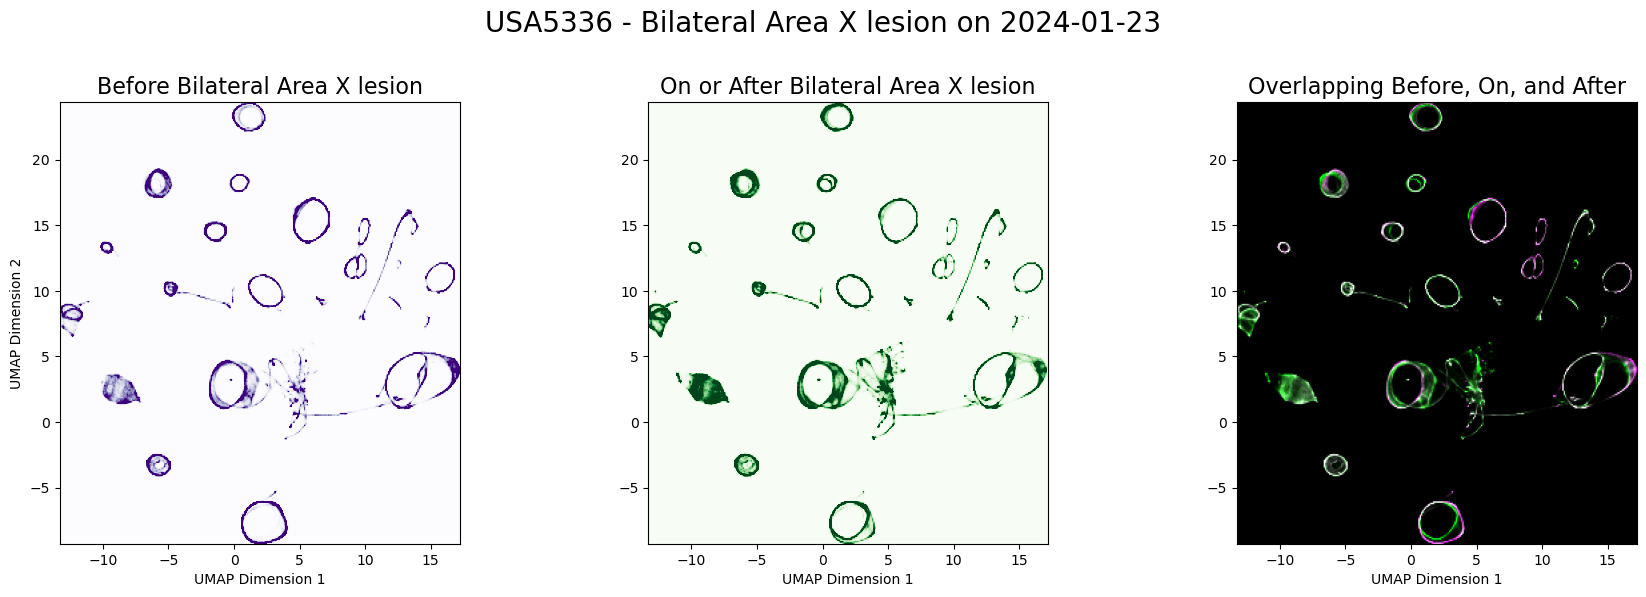

In [158]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# Paths to the .npz and .json files
# path_to_npz_file_from_TweetyBERT = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508.npz'
# path_to_json_file_with_dates = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508_creation_data.json'

# Extract the animal ID using regex
match = re.search(r"(USA\d{4})", path_to_npz_file_from_TweetyBERT)
if match:
    animal_id = match.group(1)
    print(f"Animal ID: {animal_id}")
else:
    print("Animal ID not found in the file path.")

# Load the JSON file and extract treatment details
with open(path_to_json_file_with_dates, 'r') as file:
    json_data = json.load(file)

treatment_date_str = json_data.get("treatment_date", "Treatment date not found")
treatment_type = json_data.get("treatment_type", "Treatment type not found")
print(f"Treatment Date: {treatment_date_str}")
print(f"Treatment Type: {treatment_type}")

# Convert treatment date to datetime
treatment_date = pd.to_datetime(treatment_date_str)

# Assuming 'final_df' is your DataFrame with 'Date' and 'Coordinate' columns
final_df['Date'] = pd.to_datetime(final_df['Date'])

# Split 'Coordinate' column into 'X' and 'Y'
coordinates = pd.DataFrame(final_df['Coordinate'].tolist(), columns=['X', 'Y'])
final_df[['X', 'Y']] = coordinates

# Filter coordinates based on treatment date
before_treatment = final_df[final_df['Date'] < treatment_date]
after_treatment = final_df[final_df['Date'] >= treatment_date]

# Define bins for the heatmap
bins = 300

# Create a 2D histogram for data before treatment
heatmap_before, xedges, yedges = np.histogram2d(before_treatment['X'], before_treatment['Y'], bins=bins)

# Create a 2D histogram for data after treatment
heatmap_after, _, _ = np.histogram2d(after_treatment['X'], after_treatment['Y'], bins=[xedges, yedges])

# Normalize each heatmap independently
heatmap_before = heatmap_before / heatmap_before.max()
heatmap_after = heatmap_after / heatmap_after.max()

# Create an RGB image with purple and green channels for overlap visualization
rgb_image = np.zeros((heatmap_before.shape[0], heatmap_before.shape[1], 3))
# Increase the intensity of the RGB channels
brightness_factor = 4  # Adjust this value as needed to make the colors brighter
rgb_image[..., 0] = np.clip(heatmap_before.T * brightness_factor, 0, 1)  # Red channel for purple
rgb_image[..., 1] = np.clip(heatmap_after.T * brightness_factor, 0, 1)   # Green channel for green
rgb_image[..., 2] = np.clip(heatmap_before.T * brightness_factor, 0, 1)  # Blue channel for purple


# Plot the two heatmaps separately and the combined RGB plot
plt.figure(figsize=(18, 6))

# Plot for data before treatment
plt.subplot(1, 3, 1)
plt.imshow(heatmap_before.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='Purples', vmax=0.1)
plt.title(f"Before {treatment_type}", fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Plot for data after treatment
plt.subplot(1, 3, 2)
plt.imshow(heatmap_after.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='Greens', vmax=0.1)
plt.title(f"On or After {treatment_type}", fontsize=16)
plt.xlabel('UMAP Dimension 1')

# Plot combined RGB image
plt.subplot(1, 3, 3)
plt.imshow(rgb_image, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower')
plt.title("Overlapping Before, On, and After", fontsize=16)
plt.xlabel('UMAP Dimension 1')

# Main title and layout
plt.suptitle(f"{animal_id} - {treatment_type} on {treatment_date_str}", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

Animal ID: USA5336
Treatment Date: 2024-01-23
Treatment Type: Bilateral Area X lesion
Number of data points before treatment: 332571
Number of data points on or after treatment: 667429


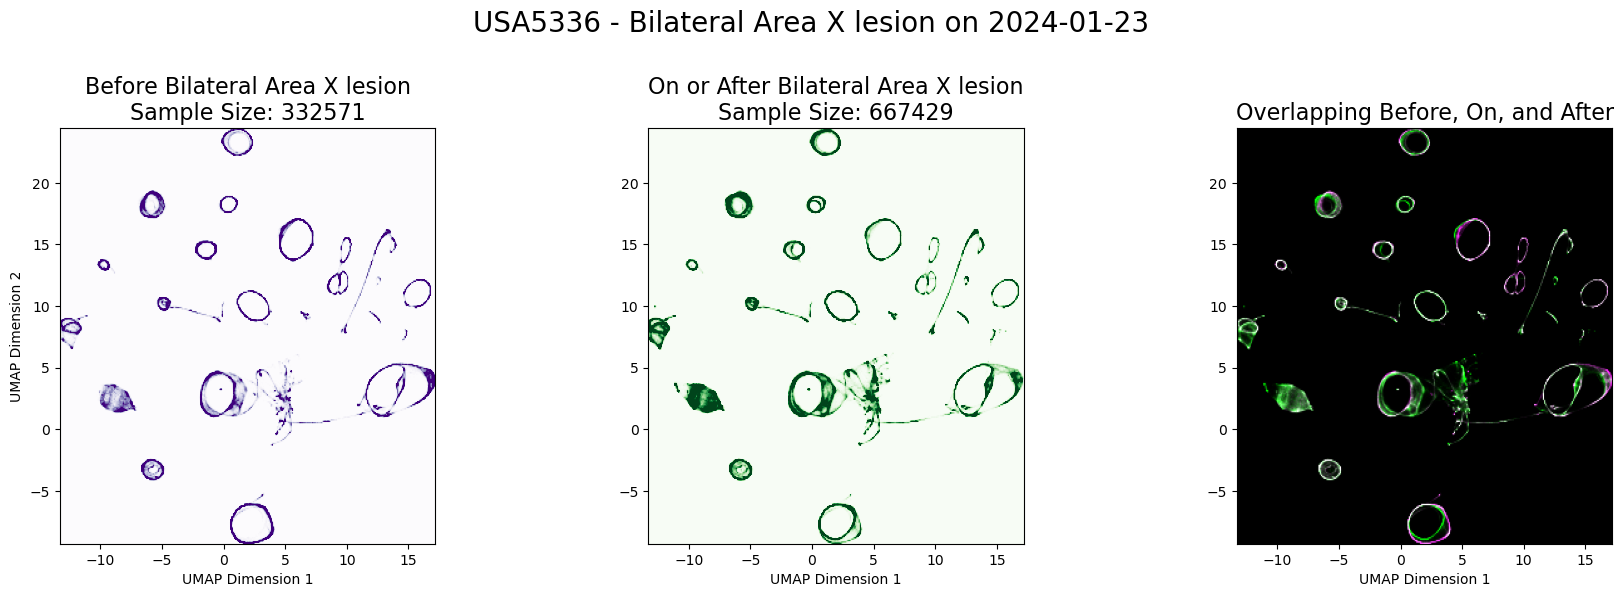

In [159]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# Paths to the .npz and .json files
# path_to_npz_file_from_TweetyBERT = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508.npz'
# path_to_json_file_with_dates = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508_creation_data.json'

# Extract the animal ID using regex
match = re.search(r"(USA\d{4})", path_to_npz_file_from_TweetyBERT)
if match:
    animal_id = match.group(1)
    print(f"Animal ID: {animal_id}")
else:
    print("Animal ID not found in the file path.")

# Load the JSON file and extract treatment details
with open(path_to_json_file_with_dates, 'r') as file:
    json_data = json.load(file)

treatment_date_str = json_data.get("treatment_date", "Treatment date not found")
treatment_type = json_data.get("treatment_type", "Treatment type not found")
print(f"Treatment Date: {treatment_date_str}")
print(f"Treatment Type: {treatment_type}")

# Convert treatment date to datetime
treatment_date = pd.to_datetime(treatment_date_str)

# Assuming 'final_df' is your DataFrame with 'Date' and 'Coordinate' columns
final_df['Date'] = pd.to_datetime(final_df['Date'])

# Split 'Coordinate' column into 'X' and 'Y'
coordinates = pd.DataFrame(final_df['Coordinate'].tolist(), columns=['X', 'Y'])
final_df[['X', 'Y']] = coordinates

# Filter coordinates based on treatment date
before_treatment = final_df[final_df['Date'] < treatment_date]
after_treatment = final_df[final_df['Date'] >= treatment_date]

# Print the number of datapoints for each dataset
num_before = len(before_treatment)
num_after = len(after_treatment)
print(f"Number of data points before treatment: {num_before}")
print(f"Number of data points on or after treatment: {num_after}")

# Define bins for the heatmap
bins = 300

# Create a 2D histogram for data before treatment
heatmap_before, xedges, yedges = np.histogram2d(before_treatment['X'], before_treatment['Y'], bins=bins)

# Create a 2D histogram for data after treatment
heatmap_after, _, _ = np.histogram2d(after_treatment['X'], after_treatment['Y'], bins=[xedges, yedges])

# Normalize each heatmap independently
heatmap_before = heatmap_before / heatmap_before.max()
heatmap_after = heatmap_after / heatmap_after.max()

# Create an RGB image with purple and green channels for overlap visualization
rgb_image = np.zeros((heatmap_before.shape[0], heatmap_before.shape[1], 3))
# Increase the intensity of the RGB channels
brightness_factor = 4  # Adjust this value as needed to make the colors brighter
rgb_image[..., 0] = np.clip(heatmap_before.T * brightness_factor, 0, 1)  # Red channel for purple
rgb_image[..., 1] = np.clip(heatmap_after.T * brightness_factor, 0, 1)   # Green channel for green
rgb_image[..., 2] = np.clip(heatmap_before.T * brightness_factor, 0, 1)  # Blue channel for purple

# Plot the two heatmaps separately and the combined RGB plot
plt.figure(figsize=(18, 6))

# Plot for data before treatment
plt.subplot(1, 3, 1)
plt.imshow(heatmap_before.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='Purples', vmax=0.1)
plt.title(f"Before {treatment_type}\nSample Size: {num_before}", fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Plot for data after treatment
plt.subplot(1, 3, 2)
plt.imshow(heatmap_after.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='Greens', vmax=0.1)
plt.title(f"On or After {treatment_type}\nSample Size: {num_after}", fontsize=16)
plt.xlabel('UMAP Dimension 1')

# Plot combined RGB image
plt.subplot(1, 3, 3)
plt.imshow(rgb_image, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower')
plt.title("Overlapping Before, On, and After", fontsize=16)
plt.xlabel('UMAP Dimension 1')

# Main title and layout
plt.suptitle(f"{animal_id} - {treatment_type} on {treatment_date_str}", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()


## Make ALL the graphs brighter

In [160]:
# import re
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import json

# # Paths to the .npz and .json files
# path_to_npz_file_from_TweetyBERT = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508.npz'
# path_to_json_file_with_dates = '/Users/mirandahulsey-vincent/Documents/allPythonCode/syntax_analysis/data_inputs/DOI_USA5508/DOI_USA5508_creation_data.json'

# # Extract the animal ID using regex
# match = re.search(r"(USA\d{4})", path_to_npz_file_from_TweetyBERT)
# if match:
#     animal_id = match.group(1)
#     print(f"Animal ID: {animal_id}")
# else:
#     print("Animal ID not found in the file path.")

# # Load the JSON file and extract treatment details
# with open(path_to_json_file_with_dates, 'r') as file:
#     json_data = json.load(file)

# treatment_date_str = json_data.get("treatment_date", "Treatment date not found")
# treatment_type = json_data.get("treatment_type", "Treatment type not found")
# print(f"Treatment Date: {treatment_date_str}")
# print(f"Treatment Type: {treatment_type}")

# # Convert treatment date to datetime
# treatment_date = pd.to_datetime(treatment_date_str)

# # Assuming 'final_df' is your DataFrame with 'Date' and 'Coordinate' columns
# final_df['Date'] = pd.to_datetime(final_df['Date'])

# # Split 'Coordinate' column into 'X' and 'Y'
# coordinates = pd.DataFrame(final_df['Coordinate'].tolist(), columns=['X', 'Y'])
# final_df[['X', 'Y']] = coordinates

# # Filter coordinates based on treatment date
# before_treatment = final_df[final_df['Date'] < treatment_date]
# after_treatment = final_df[final_df['Date'] >= treatment_date]

# # Define bins for the heatmap
# bins = 300

# # Create a 2D histogram for data before treatment
# heatmap_before, xedges, yedges = np.histogram2d(before_treatment['X'], before_treatment['Y'], bins=bins)

# # Create a 2D histogram for data after treatment
# heatmap_after, _, _ = np.histogram2d(after_treatment['X'], after_treatment['Y'], bins=[xedges, yedges])

# # Normalize each heatmap independently
# heatmap_before = heatmap_before / heatmap_before.max()
# heatmap_after = heatmap_after / heatmap_after.max()

# # Create an RGB image with purple and green channels for overlap visualization
# rgb_image = np.zeros((heatmap_before.shape[0], heatmap_before.shape[1], 3))
# # Increase the intensity of the RGB channels
# brightness_factor = 4  # Adjust this value as needed to make the colors brighter
# rgb_image[..., 0] = np.clip(heatmap_before.T * brightness_factor, 0, 1)  # Red channel for purple
# rgb_image[..., 1] = np.clip(heatmap_after.T * brightness_factor, 0, 1)   # Green channel for green
# rgb_image[..., 2] = np.clip(heatmap_before.T * brightness_factor, 0, 1)  # Blue channel for purple


# # Plot the two heatmaps separately and the combined RGB plot
# # Set a brightness factor for the heatmap plots
# heatmap_brightness_factor = 0.5  # Adjust this value to control brightness; lower values = brighter colors

# plt.figure(figsize=(18, 6))

# # Plot for data before treatment with increased brightness
# plt.subplot(1, 3, 1)
# plt.imshow(heatmap_before.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='Purples', vmax=heatmap_brightness_factor)
# plt.title(f"Before {treatment_type}", fontsize=16)
# plt.xlabel('UMAP Dimension 1')
# plt.ylabel('UMAP Dimension 2')

# # Plot for data after treatment with increased brightness
# plt.subplot(1, 3, 2)
# plt.imshow(heatmap_after.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='Greens', vmax=heatmap_brightness_factor)
# plt.title(f"On or After {treatment_type}", fontsize=16)
# plt.xlabel('UMAP Dimension 1')

# # Adjust the RGB image plot as before
# brightness_factor = 2  # Adjust as needed for the rightmost plot
# rgb_image[..., 0] = np.clip(heatmap_before.T * brightness_factor, 0, 1)  # Red channel for purple
# rgb_image[..., 1] = np.clip(heatmap_after.T * brightness_factor, 0, 1)   # Green channel for green
# rgb_image[..., 2] = np.clip(heatmap_before.T * brightness_factor, 0, 1)  # Blue channel for purple

# # Plot combined RGB image with increased brightness
# plt.subplot(1, 3, 3)
# plt.imshow(rgb_image, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower')
# plt.title("Before and On or After Overlap", fontsize=16)
# plt.xlabel('UMAP Dimension 1')

# # Main title and layout
# plt.suptitle(f"{animal_id} - {treatment_type} on {treatment_date_str}", fontsize=20)
# plt.tight_layout(rect=[0, 0, 1, 0.96])

# plt.show()
